In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!cp -r /content/drive/MyDrive/ECG data

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from itertools import product
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
LABEL_COL = 187
DATASET = "mitbih"
BATCH_SIZE = 256

In [ ]:
scaler = StandardScaler()

In [ ]:
if DATASET == "mitbih":
    mit_bih_train = pd.read_csv(os.path.join("data","ECG","mitbih_train.csv"),header=None)
    target_train = mit_bih_train[LABEL_COL].copy().values
    mit_bih_train.drop(LABEL_COL,axis=1,inplace=True)

    mit_bih_test = pd.read_csv(os.path.join("data","ECG","mitbih_test.csv"),header=None)
    target_test = mit_bih_test[LABEL_COL].copy().values
    mit_bih_test.drop(LABEL_COL,axis=1,inplace=True)

    train_features = mit_bih_train.values
    test_features = mit_bih_test.values

scaler = scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


In [ ]:
X_train = torch.tensor(train_features,dtype=torch.float32)
y_train = torch.tensor(target_train,dtype=torch.int64)
X_test = torch.tensor(test_features,dtype=torch.float32)
y_test = torch.tensor(target_test,dtype=torch.int64)

In [ ]:
X_train = torch.cat([X_train, X_train[torch.where(y_train == 3)[0]].repeat(3,1)],dim=0)

In [ ]:
y_train = torch.cat([y_train, y_train[torch.where(y_train == 3)[0]].repeat(3)],dim=0)

In [ ]:
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [ ]:
class MLPNet(nn.Module):

    def __init__(self, in_dim = 187, n_units=[128,32], num_classes=5, dropout=0.0, **kwargs):
        super(MLPNet, self).__init__(**kwargs)

        self.n_units = [in_dim] + n_units + [num_classes]

        self.dropout = nn.Dropout(dropout)
        self.linear_layers = nn.ModuleList([
            nn.Linear(self.n_units[idx], self.n_units[idx+1]) for idx in range(len(self.n_units)-1)
        ])

    def forward(self, x):

        for layer in self.linear_layers[:-1]:
            x = layer(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.linear_layers[-1](x)

        return x
    
class ConvNet(nn.Module):

    def __init__(self, in_channels = 1, n_units = [32, 64, 128], num_classes=5, dropout=0.0, **kwargs):
        super(ConvNet, self).__init__(**kwargs)

        self.n_units = [in_channels] + n_units

        self.convs = nn.ModuleList([
            nn.Conv1d(self.n_units[idx], self.n_units[idx+1], kernel_size=3, padding="same") for idx in range(len(self.n_units)-1)
        ])

        self.dropout = nn.Dropout(dropout)
        self.cls_head = MLPNet(self.n_units[-1], n_units=[64,16], num_classes=num_classes)

    def forward(self, x):

        x = x.unsqueeze(-1)
        x = x.transpose(1,2)

        for layer in self.convs:
            x = F.max_pool1d(F.relu(layer(x)), kernel_size=2)
            x = self.dropout(x)
        
        feat = x.mean(2)

        return self.cls_head(feat)
    

class LSTMNet(nn.Module):

    def __init__(self, in_channels = 1, hidden_size=128, dropout=0.2, bidirectional=True, num_layers=1, num_classes=5, **kwargs):
        super(LSTMNet, self).__init__(**kwargs)

        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional,
            num_layers=num_layers
        )

        self.hidden_size = hidden_size


        self.cls_head = MLPNet(hidden_size,[32],num_classes)

    def forward(self, x):

        x = x.unsqueeze(-1)
        batch_size, seq_len, _ = x.shape
        feat = self.lstm(x)[0].view(batch_size,seq_len,-1,self.hidden_size)[:,-1,:,:].mean(1)

        return self.cls_head(feat)
        

In [ ]:
in_dim = train_features.shape[-1]
num_classes = len(np.unique(target_train))

In [ ]:
MODEL = "lstm" # ["mlp", "conv", "lstm"]
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PARAM_VALUES = None
MODEL_PARAM_NAMES = None

In [ ]:
if MODEL == "mlp":

    n_units = [[128, 32], [128, 64], [64, 16], [128, 64, 16]]
    dropout = [0.0, 0.4]
    MODEL_PARAM_VALUES = [n_units, dropout]
    MODEL_PARAM_NAMES = ["n_units", "dropout"]
    
elif MODEL == "conv":

    n_units = [[32, 64, 128], [32, 64], [32, 64, 128, 256]]
    dropout = [0.0, 0.4]
    MODEL_PARAM_VALUES = [n_units, dropout]
    MODEL_PARAM_NAMES = ["n_units", "dropout"]

elif MODEL == "lstm":

    hidden_size = [128]
    bidirectional = [True]
    num_layers = [2]
    dropout = [0.0]
    MODEL_PARAM_VALUES = [hidden_size, bidirectional, num_layers, dropout]
    MODEL_PARAM_NAMES = ["hidden_size", "bidirectional", "num_layers", "dropout"]

In [ ]:
def train_epoch(train_loader, epoch, train_losses):
    model.train()
    step_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        step_losses.append(loss.item())
    
    train_losses.append(np.mean(step_losses))
    print(f"Epoch {epoch}:{np.mean(step_losses):.3f}")

def eval_epoch(test_loader, test_losses):
    model.eval()
    step_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)
            step_losses.append(loss.item())
    test_losses.append(np.mean(step_losses))


In [ ]:
def metrics(test_loader,config):
    class_totals = pd.Series(target_test).value_counts()
    total = test_features.shape[0]
    correct = 0
    per_class = [{k:0 for k in ["tp","fp","fn"]} for _ in range(len(class_totals))]

    res = {"Configuration": [str(config)]}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            preds = output.argmax(1)
            correct += sum(preds == target).item()
            for class_id in range(len(class_totals)):
                per_class[class_id]["tp"] += sum(torch.logical_and(preds == class_id, target == class_id)).item()
                per_class[class_id]["fp"] += sum(torch.logical_and(preds == class_id, target != class_id)).item()
                per_class[class_id]["fn"] += sum(torch.logical_and(preds != class_id, target == class_id)).item()

    res.update({"Accuracy": correct/total})
    for class_id in range(len(class_totals)):

        a = per_class[class_id]["tp"]+per_class[class_id]["fp"]
        b = per_class[class_id]["tp"]+per_class[class_id]["fn"]

        prec = 0.0
        if a > 0:
            prec = per_class[class_id]["tp"]/a

        recall = 0.0
        if b > 0:
            recall = per_class[class_id]["tp"]/b

        f1 = 0.0
        if (prec + recall) > 0.0:
            f1 = (2 * prec * recall)/(prec + recall)
        
        res.update({f"{class_id}_prec": [prec], f"{class_id}_recall": [recall], f"{class_id}_f1": [f1]})
    return res

In [ ]:
header = {"Configuration":[],"Accuracy":[]}
header.update({f"{idx}_{metric}":[] for idx,metric in product(list(range(num_classes)), ["prec","recall","f1"])})

In [ ]:
df = pd.DataFrame.from_dict(header)

In [ ]:
losses_series = []

for configuration in product(*MODEL_PARAM_VALUES):
    config = {k:v for k, v in zip(MODEL_PARAM_NAMES, configuration)}
    if MODEL == "mlp":
        model = MLPNet(in_dim=in_dim,num_classes=num_classes, **config)
    elif MODEL == "conv":
        model = ConvNet(in_channels=1,num_classes=num_classes, **config)
    elif MODEL == "lstm":
        model = LSTMNet(in_channels=1,num_classes=num_classes, **config)

    optimizer = optim.Adam(model.parameters(),lr=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=1e-4)
    criterion = nn.CrossEntropyLoss()
    model = model.to(DEVICE)

    train_losses = []
    test_losses = []
    print(config)
    for epoch in range(EPOCHS):
        train_epoch(train_loader, epoch, train_losses)
        eval_epoch(test_loader, test_losses)
        scheduler.step()

    losses_series.append((train_losses, test_losses))

    res = metrics(test_loader, config)

    df = pd.concat([df, pd.DataFrame.from_dict(res)], ignore_index=True)

{'hidden_size': 128, 'bidirectional': True, 'num_layers': 2, 'dropout': 0.0}
Epoch 0:0.701
Epoch 1:0.643
Epoch 2:0.511
Epoch 3:0.388
Epoch 4:0.360
Epoch 5:0.352
Epoch 6:0.305
Epoch 7:0.262
Epoch 8:0.238
Epoch 9:0.269
Epoch 10:0.203
Epoch 11:0.174
Epoch 12:0.161
Epoch 13:0.156
Epoch 14:0.149
Epoch 15:0.136
Epoch 16:0.121
Epoch 17:0.101
Epoch 18:0.087
Epoch 19:0.073


In [ ]:
df.round(3)

,Configuration,Accuracy,0_prec,0_recall,0_f1,1_prec,1_recall,1_f1,2_prec,2_recall,2_f1,3_prec,3_recall,3_f1,4_prec,4_recall,4_f1
0,"{'hidden_size': 128, 'bidirectional': True, 'n...",0.978,0.981,0.997,0.989,0.924,0.594,0.723,0.951,0.942,0.947,0.767,0.568,0.652,0.991,0.973,0.982


In [ ]:
df.to_excel(f"{MODEL}_results.xlsx")

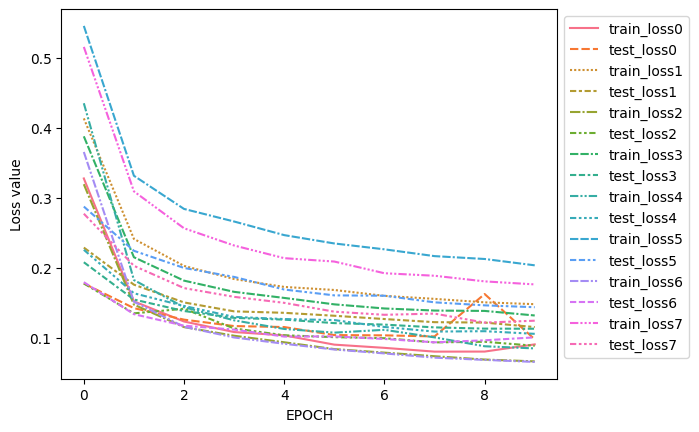

In [ ]:
losses_dict = {}

for idx, elem in enumerate(losses_series):
    losses_dict.update({
        f"train_loss{idx}": elem[0],
        f"test_loss{idx}": elem[1]
    })

losses = pd.DataFrame(losses_dict)

ax = sns.lineplot(losses)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("EPOCH")
plt.ylabel("Loss value")
plt.show()